# References

### [sklearn]
- https://www.kaggle.com/mchirico/quick-look-seaborn-wordcloud
- https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

### [pytorch]
- https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [186]:
import warnings
warnings.filterwarnings("ignore")

In [187]:
from io import StringIO
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from text_processing import text_preprocessing
from wordcloud import WordCloud

# Data Preparation

- train-test split
- batch-loading
- data preparation for MIMIC from postgres
- null handling = sMOTE or other conventional methods
- auxilliary data for netflix needs to be collected

![](static/privacygan_titatic_preprocessing.png)

### Dataset 01: Titanic
- source: https://www.kaggle.com/c/titanic/data
- predict the survival based on passenger information

In [188]:
df_data = pd.read_csv('data/titanic.csv')
len_prev = len(df_data)
df_data.drop(['Cabin'], axis=1, inplace=True)
df_data.dropna(inplace=True)
len_curr = len(df_data)
print("{} rows with null values dropped".format(len_prev-len_curr))
print("{} rows of data available".format(len_curr))
df_data.head(3)

179 rows with null values dropped
712 rows of data available


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


### Text Preprocessing
- making text case insensitive
- handling special characters
- can possibly help match more columns in case of noisy data 
- standardize the categorical columns to prevent more dummy variables.

In [189]:
for col in ['Name', 'Sex', 'Embarked', 'Ticket']:
    df_data[col+'_preprocessed'] = list(map(text_preprocessing, df_data[col].tolist()))
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_preprocessed,Sex_preprocessed,Embarked_preprocessed,Ticket_preprocessed
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,braund mr owen harris,male,s,a 5 21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,cumings mrs john bradley florence briggs thayer,female,c,pc 17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,heikkinen miss laina,female,s,ston o2 3101282


### Visualizations

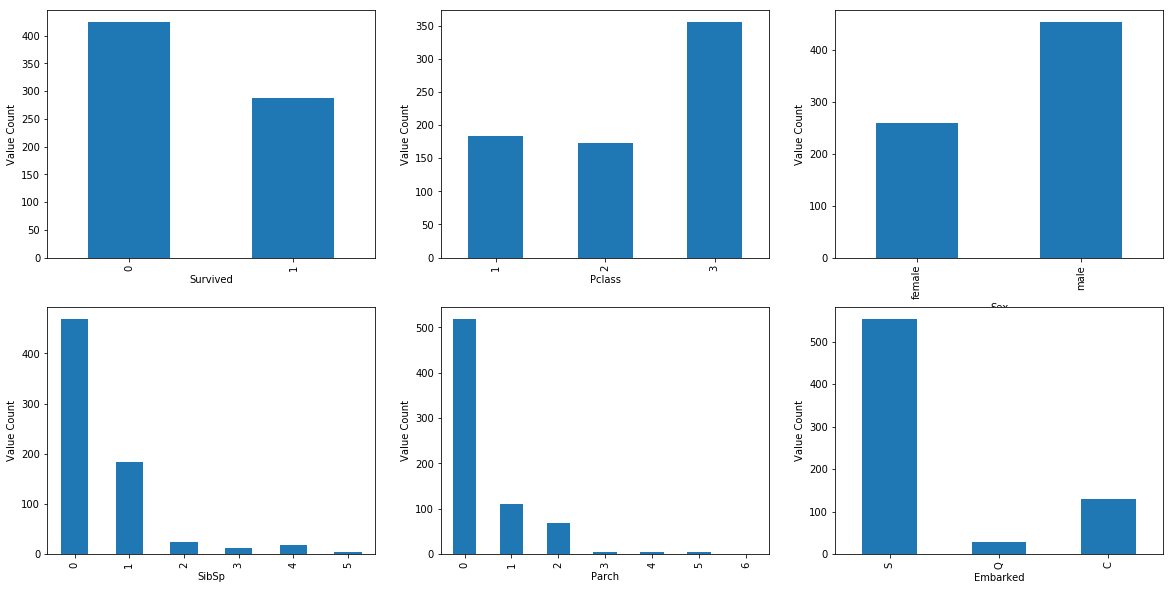

In [190]:
categorical_columns = [
    'Survived', 
    'Pclass', 
    'Sex', 
    'SibSp', 
    'Parch', 
    'Embarked'
]

num_cols = 3
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(categorical_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[categorical_columns[col]].value_counts(sort=False).plot(kind='bar')
    plt.xlabel(categorical_columns[col])
    plt.ylabel('Value Count')
plt.show()

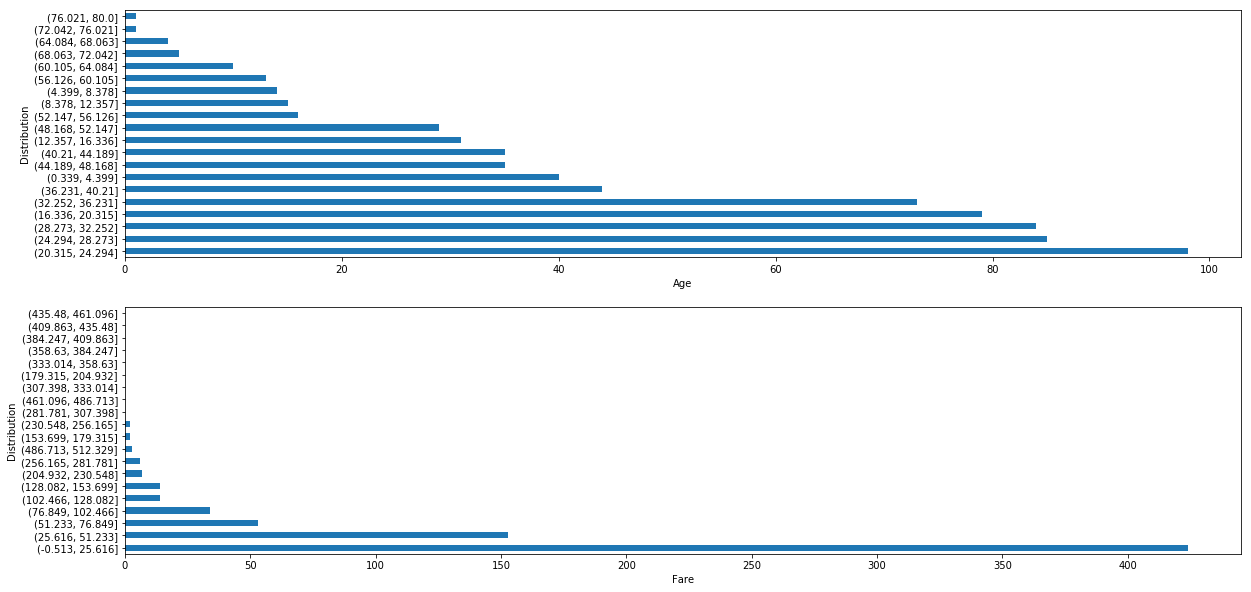

In [191]:
continuous_variables = [
    'Age', 
    'Fare'
]

num_cols = 1
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(continuous_variables)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[continuous_variables[col]].value_counts(bins=20, sort=True).plot(kind='barh')
    plt.xlabel(continuous_variables[col])
    plt.ylabel('Distribution')
plt.show()


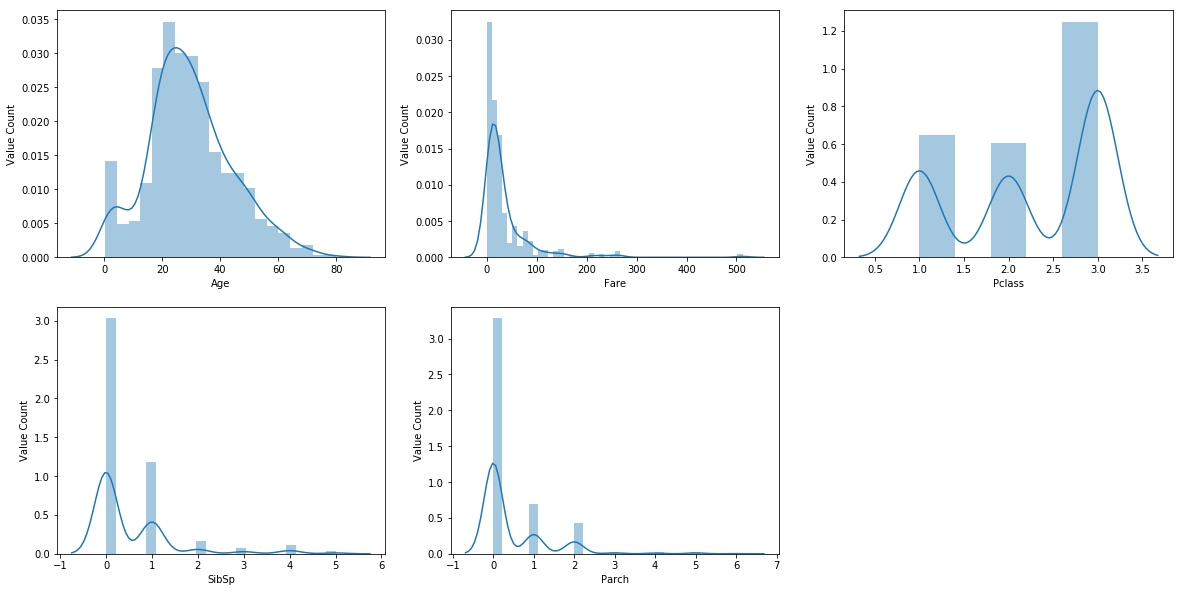

In [192]:
dist_columns = [
    'Age',
    'Fare',
    'Pclass',
    'SibSp',
    'Parch'
]

num_cols = 3
num_rows = math.ceil(len(dist_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(dist_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    sns.distplot(df_data[dist_columns[col]])
    plt.xlabel(dist_columns[col])
    plt.ylabel('Value Count')
plt.show()

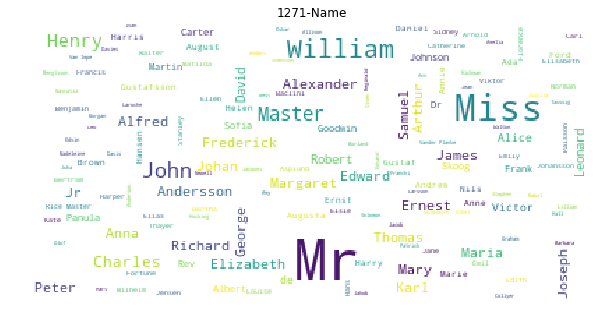

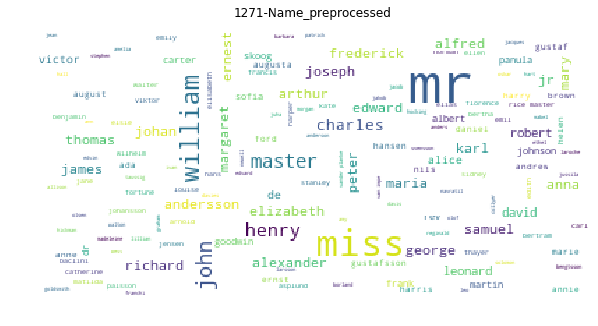

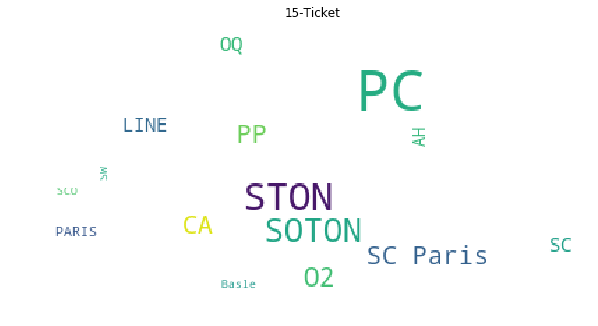

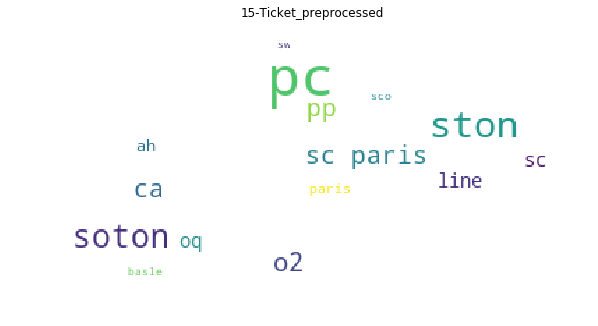

In [193]:
text_columns = ['Name', 'Name_preprocessed', 'Ticket', 'Ticket_preprocessed']

for col in range(len(text_columns)):
    si=StringIO()
    df_data[text_columns[col]].apply(lambda x: si.write(str(x) + " "))
    text=si.getvalue()
    si.close()

    wordcloud = WordCloud(width=1600, height=1600, max_words=100).generate(text)
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40, 
        relative_scaling=.5
    ).generate(text)
    plt.figure(figsize=(10, 20))
    plt.imshow(wordcloud)
    plt.title("{}-{}".format(str(len(wordcloud.words_)), text_columns[col]))
    plt.axis("off")
    plt.show()

### Definition of Ally and Adversary Variables.
- Ally target: Survived
- Adversary target: Sex
- The choice of adversary target can be changed.
- Chosen M/F here as it will be possible to have train-test split or k-fold validation

In [194]:
for col in ["Name", "Sex", "Embarked", "Ticket"]:
    df_data[col] = df_data[col+"_preprocessed"]
    df_data.drop([col+"_preprocessed"], axis=1, inplace=True)
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,braund mr owen harris,male,22.0,1,0,a 5 21171,7.2500,s
1,2,1,1,cumings mrs john bradley florence briggs thayer,female,38.0,1,0,pc 17599,71.2833,c
2,3,1,3,heikkinen miss laina,female,26.0,0,0,ston o2 3101282,7.9250,s


In [195]:
df_data = pd.get_dummies(df_data, columns=['Sex'], drop_first=True)
df_data = pd.get_dummies(df_data, columns=['Pclass', 'SibSp', 'Parch', 'Embarked'])
df_data.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Sex_male,Pclass_1,Pclass_2,Pclass_3,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,1,0,braund mr owen harris,22.0,a 5 21171,7.2500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2,1,cumings mrs john bradley florence briggs thayer,38.0,pc 17599,71.2833,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,heikkinen miss laina,26.0,ston o2 3101282,7.9250,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1,futrelle mrs jacques heath lily may peel,35.0,113803,53.1000,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,allen mr william henry,35.0,373450,8.0500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [196]:
y_ally = np.array(df_data.Survived.tolist())
y_advr = np.array(df_data.Sex_male.tolist())

tmp = y_ally
y_ally = y_advr
y_advr = tmp

df_data.drop(['Survived', 'Sex_male'], axis=1, inplace=True)

- using One hot encoding to convert the categorical data into dummy variables.
- Alternatively: [Managing categorical variables in pandas dataframe](http://benalexkeen.com/mapping-categorical-data-in-pandas/)
- Using count vectorizer to convert the text data into features based on bow model.

In [197]:
vectorizer = CountVectorizer()
Name = vectorizer.fit_transform(df_data.Name.tolist()).toarray()
vectorizer = CountVectorizer(vocabulary=wordcloud.words_.keys())
Ticket = vectorizer.fit_transform(df_data.Ticket.tolist()).toarray()

In [198]:
df_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df_data.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,22.0,7.2500,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [199]:
X = np.concatenate((df_data.values, Name, Ticket), axis=1)
y_ally.shape, y_advr.shape, X.shape

((712,), (712,), (712, 1324))

### Train Test Split

- This step is required before the Scaling or PCA is learnt on the train dataset and then used to transform the test dataset.

In [200]:
X_train, X_valid, y_ally_train, y_ally_valid, y_advr_train, y_advr_valid = train_test_split(
    X, 
    y_ally,
    y_advr,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_train.shape, y_advr_valid.shape

((640, 1324), (72, 1324), (640,), (72,), (640,), (72,))

### Checking the distribution after the split

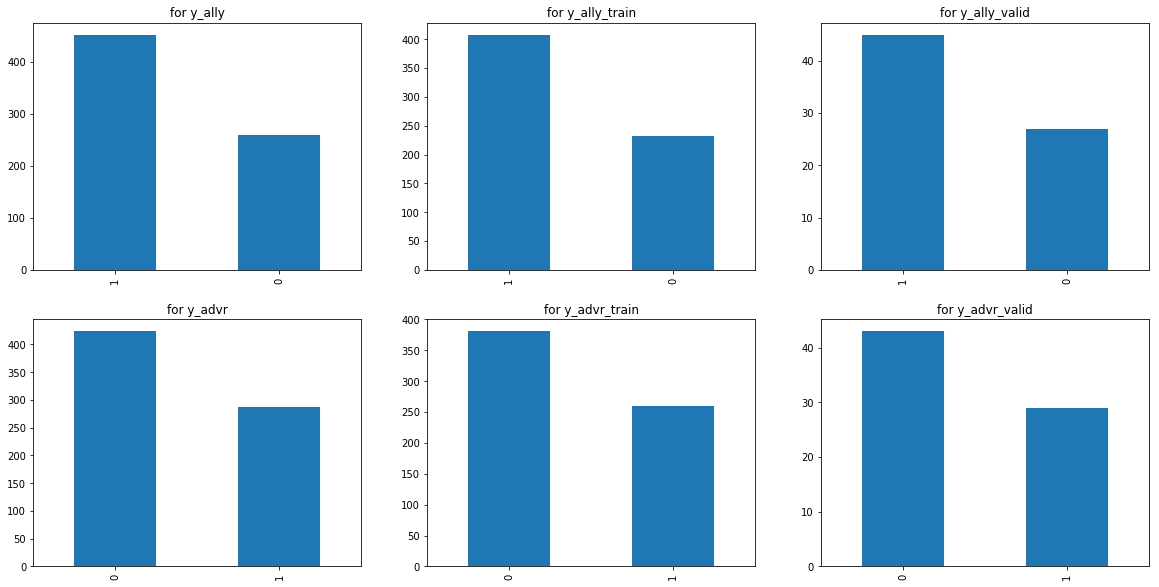

In [201]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(2, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(2, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(2, 3, 4)
pd.value_counts(y_advr).plot(kind='bar')
plt.title('for y_advr')
plt.subplot(2, 3, 5)
pd.value_counts(y_advr_train).plot(kind='bar')
plt.title('for y_advr_train')
plt.subplot(2, 3, 6)
pd.value_counts(y_advr_valid).plot(kind='bar')
plt.title('for y_advr_valid')
plt.show()

### Scaler
- Perform minmax scaling for removing the skewness which might effect the gradient descent during neural network training. 
- It is necessary to do this scaling before PCA is applied

In [202]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

![](static/privacygan_titanic_experiment.png)

### Apply PCA and select components using explained variances

In [203]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

In [204]:
num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9900398929592745 591


In [205]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((640, 591), (72, 591))

### Apply Auto-encoder for dimensionality reduction

![](static/privacygan_titanic_autoencoder.png)

In [206]:
import torch
import torch.utils.data as utils
import torch.nn as nn

In [207]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

X_train_torch = torch.Tensor(X_train_normalized).to(device)
X_valid_torch = torch.Tensor(X_valid_normalized).to(device)
y_ally_train_torch = torch.Tensor(y_ally_train.reshape(-1, 1)).to(device)
y_ally_valid_torch = torch.Tensor(y_ally_valid.reshape(-1, 1)).to(device)
y_advr_train_torch = torch.Tensor(y_advr_train.reshape(-1, 1)).to(device)
y_advr_valid_torch = torch.Tensor(y_advr_valid.reshape(-1, 1)).to(device)

DType: torch.float32
Cuda available: True
Device: cuda


In [208]:
X_train_torch.shape, X_valid_torch.shape, \
y_ally_train_torch.shape, y_ally_valid_torch.shape, \
y_advr_train_torch.shape, y_advr_valid_torch.shape

(torch.Size([640, 1324]),
 torch.Size([72, 1324]),
 torch.Size([640, 1]),
 torch.Size([72, 1]),
 torch.Size([640, 1]),
 torch.Size([72, 1]))

In [209]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [210]:
auto_encoder = AutoEncoder(input_size=X_train.shape[1],encoding_dim=X_train_reduced.shape[1]).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.001)

In [211]:
print("epoch \t Aencoder_train \t Aencoder_valid")

ae_epoch = []
ae_train = []
ae_valid = []

for epoch in range(501):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_train_torch_hat = auto_encoder(X_train_torch)
    ae_loss = criterion(X_train_torch_hat, X_train_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    if epoch%50!=0:
        continue
        
    auto_encoder.eval()
    
    X_valid_torch_hat = auto_encoder(X_valid_torch)
    ae_valid_loss = criterion(X_valid_torch_hat, X_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss
    ))
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_valid_loss)

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 1.17556572 	 0.61618793
50 	 0.84267837 	 0.34152499
100 	 0.83285195 	 0.33185205
150 	 0.83157521 	 0.33001482
200 	 0.83133233 	 0.32925591
250 	 0.83122361 	 0.32879558
300 	 0.83116353 	 0.32847789
350 	 0.83112639 	 0.32824561
400 	 0.83110160 	 0.32806647
450 	 0.83108389 	 0.32792163
500 	 0.83107078 	 0.32780260


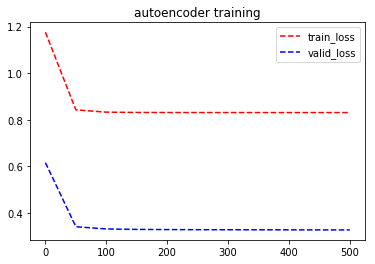

In [212]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss', 'valid_loss'])
plt.title("autoencoder training")
plt.show()

In [213]:
auto_encoder.eval()
X_train_torch_ae = auto_encoder.encoder(X_train_torch)
X_valid_torch_ae = auto_encoder.encoder(X_valid_torch)
X_train_torch_ae.shape, X_valid_torch_ae.shape

(torch.Size([640, 591]), torch.Size([72, 591]))

# GAN using Pytorch

- ["**Learning Informative and Private Representations via Generative Adversarial Networks**"](http://www.princeton.edu/~pmittal/publications/gan-bigdata18.pdf)

![](static/privacygan_titanic_privacygan.png)

### GAN V1

```python
encd_N = 64 
encd_D_in = X.shape[1]
encd_H = int(encd_D_in/2)
encd_D_out = 64

# encoder
encd_w1 = torch.randn(encd_D_in, encd_H, device=device, dtype=dtype, requires_grad=True)
encd_w2 = torch.randn(encd_H, encd_D_out, device=device, dtype=dtype, requires_grad=True)

ally_N = 64 
ally_D_in = encd_D_out
ally_H = int(ally_D_in/2)
ally_D_out = 1

# ally
ally_w1 = torch.randn(ally_D_in, ally_H, device=device, dtype=dtype, requires_grad=True)
ally_w2 = torch.randn(ally_H, ally_D_out, device=device, dtype=dtype, requires_grad=True)

advr_N = 64 
advr_D_in = encd_D_out
advr_H = int(advr_D_in/2)
advr_D_out = 2

# advr
advr_w1 = torch.randn(advr_D_in, advr_H, device=device, dtype=dtype, requires_grad=True)
advr_w2 = torch.randn(advr_H, advr_D_out, device=device, dtype=dtype, requires_grad=True)
```

### GAN V2

In [214]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [215]:
alpha = 0.5

In [216]:
encoding_dimension = X_train_reduced.shape[1]
encoder = Encoder(input_size=X_train_torch.shape[1], hidden_size=1024, output_size=encoding_dimension).cuda()
ally = Ally(input_size=encoding_dimension, hidden_size=128, output_size=y_ally_train_torch.shape[1]).cuda()
adversary = Adversary(input_size=encoding_dimension, hidden_size=128, output_size=y_advr_train_torch.shape[1]).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
encd_optimizer = optimizer(encoder.parameters(), lr = 0.001)
ally_optimizer = optimizer(ally.parameters(), lr=0.0001)
advr_optimizer = optimizer(adversary.parameters(), lr=0.000000001)

In [217]:
print("epoch \t encoder_train \t encoder_valid \t ally_train \t ally_valid \t advr_train \t advr_valid")

g_epoch = []
enc_train = []
enc_valid = []
ally_train = []
ally_valid = []
advr_train = []
advr_valid = []

for epoch in range(51):
    # set for training
    encoder.train()
    ally.train()
    adversary.train()
    
    encd_optimizer.zero_grad()
    # Forward passv
    X_train_encoding = encoder(X_train_torch)
    y_ally_train_torch_hat = ally(X_train_encoding)
    y_advr_train_torch_hat = adversary(X_train_encoding)
    # Compute Loss
    ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
    # Backward pass
    encd_loss.backward(retain_graph=True)
    encd_optimizer.step()

    for i in range(10):
        ally_optimizer.zero_grad()
        advr_optimizer.zero_grad()

        X_train_encoding = encoder(X_train_torch)
        y_ally_train_torch_hat = ally(X_train_encoding)
        y_advr_train_torch_hat = adversary(X_train_encoding)
        
        ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        
        ally_loss.backward(retain_graph=True)
        advr_loss.backward(retain_graph=True)

        ally_optimizer.step()
        advr_optimizer.step()
        
    if epoch%10!=0:
        continue

    # set for eval
    encoder.eval()
    ally.eval()
    adversary.eval()
    
    X_valid_encoding = encoder(X_valid_torch)
    y_ally_valid_torch_hat = ally(X_valid_encoding)
    y_advr_valid_torch_hat = adversary(X_valid_encoding)

    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    encd_valid_loss = alpha * ally_loss - ((1-alpha) * advr_loss)
        
    print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        encd_loss.item(),
        encd_valid_loss,
        ally_loss.item(), 
        ally_valid_loss,
        advr_loss.item(),
        advr_valid_loss,
    ))
    
    g_epoch.append(epoch)
    enc_train.append(encd_loss.item())
    enc_valid.append(encd_valid_loss.item())
    ally_train.append(ally_loss.item())
    ally_valid.append(ally_valid_loss.item())
    advr_train.append(advr_loss.item())
    advr_valid.append(advr_valid_loss.item())

epoch 	 encoder_train 	 encoder_valid 	 ally_train 	 ally_valid 	 advr_train 	 advr_valid
0 	 -0.05254307 	 -0.06039825 	 0.65167421 	 0.66061276 	 0.77247071 	 0.76647556
10 	 -0.18959938 	 -0.19409676 	 0.45602044 	 0.55918145 	 0.84421396 	 0.82358485
20 	 -0.21386839 	 -0.21534044 	 0.45188981 	 0.54552597 	 0.88257068 	 0.86065561
30 	 -0.22662340 	 -0.22773148 	 0.45212373 	 0.54933393 	 0.90758669 	 0.87237000
40 	 -0.23524663 	 -0.23578173 	 0.45160532 	 0.54280102 	 0.92316878 	 0.87489659
50 	 -0.24082600 	 -0.24140340 	 0.45141315 	 0.54188931 	 0.93421996 	 0.87585527


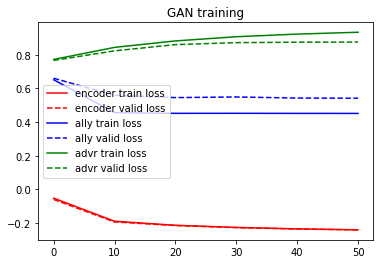

In [218]:
plt.plot(g_epoch, enc_train, 'r')
plt.plot(g_epoch, enc_valid, 'r--')
plt.plot(g_epoch, ally_train, 'b')
plt.plot(g_epoch, ally_valid, 'b--')
plt.plot(g_epoch, advr_train, 'g')
plt.plot(g_epoch, advr_valid, 'g--')
plt.legend([
    'encoder train loss', 
    'encoder valid loss',
    'ally train loss',
    'ally valid loss',
    'advr train loss',
    'advr valid loss'
])
plt.title("GAN training")
plt.show()

# Ally and Adversary Learning on Encoded Data

In [219]:
X_train_encoded = encoder(X_train_torch)
X_valid_encoded = encoder(X_valid_torch)
X_train_encoded.shape, X_valid_encoded.shape

(torch.Size([640, 591]), torch.Size([72, 591]))

In [220]:
X_train_reduced.shape, X_valid_reduced.shape

((640, 591), (72, 591))

In [221]:
y_ally_train_torch.shape, y_ally_valid_torch.shape

(torch.Size([640, 1]), torch.Size([72, 1]))

In [222]:
class Network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [223]:
lr = 0.001

network = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

n_epoch = []
train = []
valid = []
for epoch in range(501):
    network.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network(X_train_encoded)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network.eval()
    y_ally_valid_torch_hat = network(X_valid_encoded)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    n_epoch.append(epoch)
    train.append(loss.item())
    valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.65411335 	 0.64827329
50 	 0.45783493 	 0.55238599
100 	 0.45304605 	 0.54604501
150 	 0.45211393 	 0.54404575
200 	 0.45171759 	 0.54293662
250 	 0.45150515 	 0.54220623
300 	 0.45137596 	 0.54168254
350 	 0.45129070 	 0.54128540
400 	 0.45123097 	 0.54097188
450 	 0.45118728 	 0.54071689
500 	 0.45115420 	 0.54050440


In [224]:
lr = 0.0001

network_advr = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

train_a = []
valid_a = []

for epoch in range(501):
    network_advr.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr(X_train_encoded)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr.eval()
    y_advr_valid_torch_hat = network_advr(X_valid_encoded)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    train_a.append(loss.item())
    valid_a.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.77704018 	 0.77690619
50 	 0.64766186 	 0.69306099
100 	 0.60288471 	 0.67416215
150 	 0.58033293 	 0.66488457
200 	 0.56833464 	 0.65973556
250 	 0.56123054 	 0.65669608
300 	 0.55663836 	 0.65473533
350 	 0.55347437 	 0.65338874
400 	 0.55118912 	 0.65241951
450 	 0.54947609 	 0.65169483
500 	 0.54815286 	 0.65113634


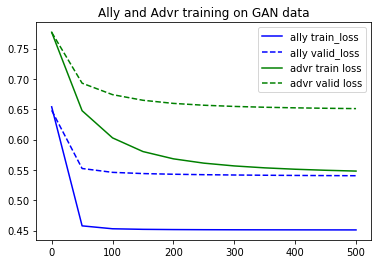

In [225]:
plt.plot(n_epoch, train, 'b')
plt.plot(n_epoch, valid, 'b--')
plt.plot(n_epoch, train_a, 'g')
plt.plot(n_epoch, valid_a, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on GAN data")
plt.show()

In [226]:
alphas = [0, 0.25, 0.5, 0.75, 1]

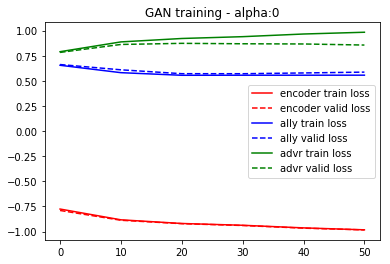

0 0.4511626362800598 0.540229082107544
0 0.5475830435752869 0.6512736678123474


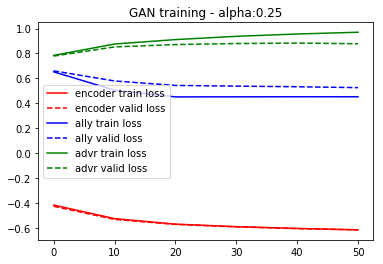

0.25 0.4511699676513672 0.5397169589996338
0.25 0.5483297109603882 0.6509745121002197


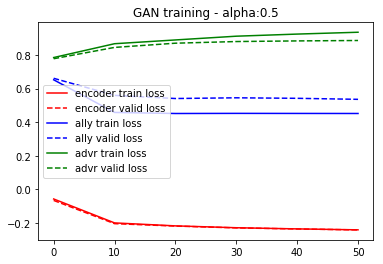

0.5 0.4511680603027344 0.5409586429595947
0.5 0.5479003190994263 0.6508880257606506


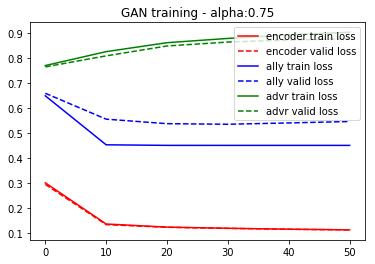

0.75 0.45115119218826294 0.5411495566368103
0.75 0.5479398965835571 0.6510346531867981


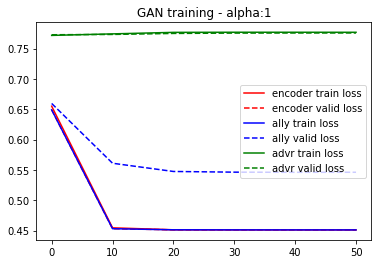

1 0.45118284225463867 0.5393029451370239
1 0.5475028157234192 0.6509056091308594


In [227]:
gan_ally_over_alpha = []
gan_advr_over_alpha = []
for alpha in alphas:
    encoder = Encoder(input_size=X_train_torch.shape[1], hidden_size=1024, output_size=encoding_dimension).cuda()
    ally = Ally(input_size=encoding_dimension, hidden_size=128, output_size=y_ally_train_torch.shape[1]).cuda()
    adversary = Adversary(input_size=encoding_dimension, hidden_size=128, output_size=y_advr_train_torch.shape[1]).cuda()

    encd_optimizer = optimizer(encoder.parameters(), lr = 0.001)
    ally_optimizer = optimizer(ally.parameters(), lr=0.0001)
    advr_optimizer = optimizer(adversary.parameters(), lr=0.000000001)
    
    g_epoch = []
    enc_train = []
    enc_valid = []
    ally_train = []
    ally_valid = []
    advr_train = []
    advr_valid = []

    for epoch in range(51):
        # set for training
        encoder.train()
        ally.train()
        adversary.train()

        encd_optimizer.zero_grad()
        # Forward passv
        X_train_encoding = encoder(X_train_torch)
        y_ally_train_torch_hat = ally(X_train_encoding)
        y_advr_train_torch_hat = adversary(X_train_encoding)
        # Compute Loss
        ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
        # Backward pass
        encd_loss.backward(retain_graph=True)
        encd_optimizer.step()

        for i in range(10):
            ally_optimizer.zero_grad()
            advr_optimizer.zero_grad()

            X_train_encoding = encoder(X_train_torch)
            y_ally_train_torch_hat = ally(X_train_encoding)
            y_advr_train_torch_hat = adversary(X_train_encoding)

            ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
            advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)

            ally_loss.backward(retain_graph=True)
            advr_loss.backward(retain_graph=True)

            ally_optimizer.step()
            advr_optimizer.step()

        if epoch%10!=0:
            continue

        # set for eval
        encoder.eval()
        ally.eval()
        adversary.eval()

        X_valid_encoding = encoder(X_valid_torch)
        y_ally_valid_torch_hat = ally(X_valid_encoding)
        y_advr_valid_torch_hat = adversary(X_valid_encoding)

        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
        encd_valid_loss = alpha * ally_loss - ((1-alpha) * advr_loss)

        g_epoch.append(epoch)
        enc_train.append(encd_loss.item())
        enc_valid.append(encd_valid_loss.item())
        ally_train.append(ally_loss.item())
        ally_valid.append(ally_valid_loss.item())
        advr_train.append(advr_loss.item())
        advr_valid.append(advr_valid_loss.item())
        
    plt.plot(g_epoch, enc_train, 'r')
    plt.plot(g_epoch, enc_valid, 'r--')
    plt.plot(g_epoch, ally_train, 'b')
    plt.plot(g_epoch, ally_valid, 'b--')
    plt.plot(g_epoch, advr_train, 'g')
    plt.plot(g_epoch, advr_valid, 'g--')
    plt.legend([
        'encoder train loss', 
        'encoder valid loss',
        'ally train loss',
        'ally valid loss',
        'advr train loss',
        'advr valid loss'
    ])
    plt.title("GAN training - alpha:" + str(alpha))
    plt.show()


    lr = 0.001

    network = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network.parameters(), lr=lr)    

    for epoch in range(501):
        network.train()
        net_optimizer.zero_grad()

        y_ally_train_torch_hat = network(X_train_encoded)
        loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

    # set for eval
    network.eval()
    y_ally_valid_torch_hat = network(X_valid_encoded)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)

    print(alpha, loss.item(), ally_valid_loss.item())
    gan_ally_over_alpha.append(ally_valid_loss.item())
    
    
    lr = 0.0001

    network_advr = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

    for epoch in range(501):
        network_advr.train()
        net_optimizer.zero_grad()

        y_advr_train_torch_hat = network_advr(X_train_encoded)
        loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

    # set for eval
    network_advr.eval()
    y_advr_valid_torch_hat = network_advr(X_valid_encoded)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    gan_advr_over_alpha.append(advr_valid_loss.item())
    print(alpha, loss.item(), advr_valid_loss.item())

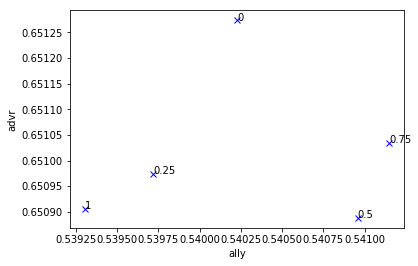

In [228]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
plt.xlabel('ally')
plt.ylabel('advr')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')

# Ally and Adversary Learning on DP Data

In [229]:
def laplaceMechanism(x, epsilon):
    x +=  torch.Tensor(np.random.laplace(0, 1.0/epsilon, x.shape)).cuda()
    return x

In [230]:
epsilon = 1

In [231]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

lr = 0.001

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

dp_ally_train = []
dp_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    
    y_ally_train_torch_hat = network_ally_pca(X_train_iter)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    dp_ally_train.append(loss.item())
    dp_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.66145360 	 0.66346264
50 	 0.51448268 	 0.62076342
100 	 0.47739026 	 0.60532653
150 	 0.46635553 	 0.60409617
200 	 0.46038944 	 0.60110456
250 	 0.45757350 	 0.59898931
300 	 0.45590034 	 0.60239440
350 	 0.45461828 	 0.60284030
400 	 0.45374414 	 0.60393649
450 	 0.45303065 	 0.60746133
500 	 0.45264721 	 0.60952163


In [232]:
lr = 0.0001

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

dp_advr_train = []
dp_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    y_advr_train_torch_hat = network_advr_pca(X_train_iter)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    dp_advr_train.append(loss.item())
    dp_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.77513498 	 0.77538764
50 	 0.70641679 	 0.75843239
100 	 0.67419809 	 0.74713528
150 	 0.65303105 	 0.74117035
200 	 0.63695186 	 0.73882484
250 	 0.62249464 	 0.73808241
300 	 0.60932732 	 0.73822504
350 	 0.59853286 	 0.73854786
400 	 0.59011585 	 0.73888355
450 	 0.58321786 	 0.73912191
500 	 0.57696170 	 0.73917222


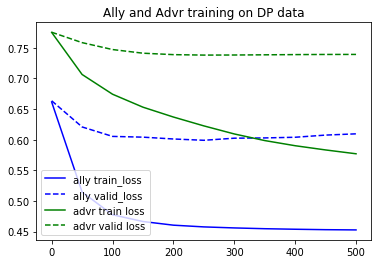

In [233]:
plt.plot(n_epoch, dp_ally_train, 'b')
plt.plot(n_epoch, dp_ally_valid, 'b--')
plt.plot(n_epoch, dp_advr_train, 'g')
plt.plot(n_epoch, dp_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on DP data")
plt.show()

In [234]:
epsilons = [1, 26, 51, 71, 101,]

1 0.4524059295654297 0.6204867362976074
1 0.5409372448921204 0.7490299344062805


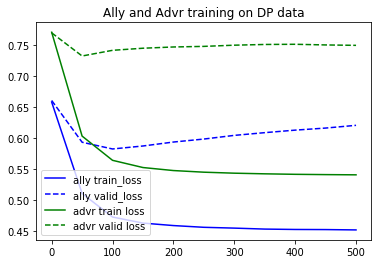

26 0.45498019456863403 0.4957778751850128
26 0.5450032353401184 0.6506016850471497


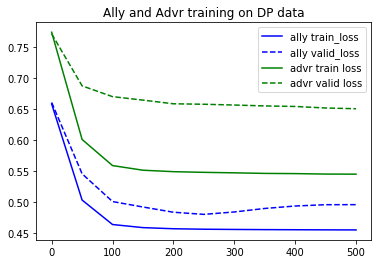

51 0.4578166902065277 0.4843469262123108
51 0.5437140464782715 0.6483963131904602


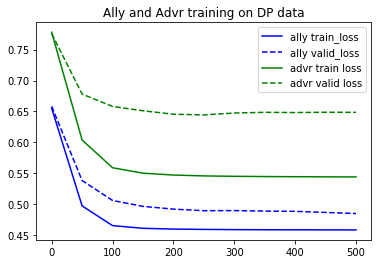

71 0.45490169525146484 0.4813424348831177
71 0.5443138480186462 0.6400464177131653


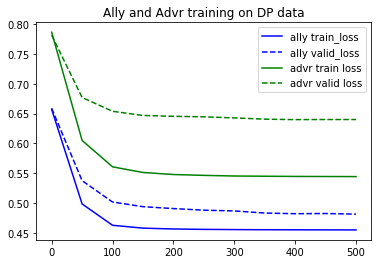

101 0.45394372940063477 0.47898250818252563
101 0.543783962726593 0.6387866139411926


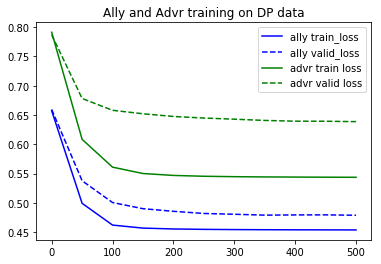

In [235]:
ally_dp_over_epsilons = []
advr_dp_over_epsilons = []
for epsilon in epsilons:
    X_train_pca_torch = torch.Tensor(X_train_reduced)
    X_valid_pca_torch = torch.Tensor(X_valid_reduced)

    lr = 0.001

    network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

    dp_ally_train = []
    dp_ally_valid = []

    X_train_pca_torch = X_train_pca_torch.to(device)
    X_valid_pca_torch = X_valid_pca_torch.to(device)
    y_ally_train_torch = y_ally_train_torch.to(device)
    y_ally_valid_torch = y_ally_valid_torch.to(device)

    for epoch in range(501):
        network_ally_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)

        y_ally_train_torch_hat = network_ally_pca(X_train_iter)
        loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%50!=0:
            continue

        # set for eval
        network_ally_pca.eval()
        y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)

        dp_ally_train.append(loss.item())
        dp_ally_valid.append(ally_valid_loss)

    ally_dp_over_epsilons.append(ally_valid_loss.item())
    print(epsilon, loss.item(), ally_valid_loss.item())

    lr = 0.001

    network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

    y_advr_train_torch = y_advr_train_torch.to(device)
    y_advr_valid_torch = y_advr_valid_torch.to(device)

    dp_advr_train = []
    dp_advr_valid = []

    for epoch in range(501):
        network_advr_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
        y_advr_train_torch_hat = network_advr_pca(X_train_iter)
        loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%50!=0:
            continue

        # set for eval
        network_advr_pca.eval()
        y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)

        dp_advr_train.append(loss.item())
        dp_advr_valid.append(advr_valid_loss)

    print(epsilon, loss.item(), advr_valid_loss.item())
    advr_dp_over_epsilons.append(advr_valid_loss.item())
    
    plt.plot(n_epoch, dp_ally_train, 'b')
    plt.plot(n_epoch, dp_ally_valid, 'b--')
    plt.plot(n_epoch, dp_advr_train, 'g')
    plt.plot(n_epoch, dp_advr_valid, 'g--')
    plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
    plt.title("Ally and Advr training on DP data")
    plt.show()

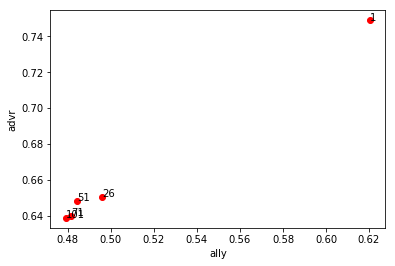

In [236]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.xlabel('ally')
plt.ylabel('advr')

for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')

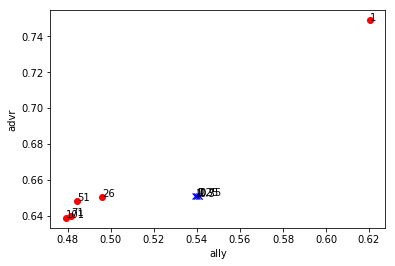

In [237]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
plt.xlabel('ally')
plt.ylabel('advr')
plt.show()

# Ally and Adversary Learning on PCA Data

In [238]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

In [239]:
lr = 0.001

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

pca_ally_train = []
pca_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_pca(X_train_pca_torch)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    pca_ally_train.append(loss.item())
    pca_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.65730840 	 0.66019702
50 	 0.49565122 	 0.53654552
100 	 0.46299657 	 0.50287384
150 	 0.45927864 	 0.49409285
200 	 0.45808673 	 0.48989370
250 	 0.45688295 	 0.48671046
300 	 0.45635939 	 0.48483649
350 	 0.45613691 	 0.48373100
400 	 0.45599538 	 0.48280716
450 	 0.45589581 	 0.48201212
500 	 0.45582166 	 0.48134714


In [240]:
lr = 0.01

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

pca_advr_train = []
pca_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_pca(X_train_pca_torch)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    pca_advr_train.append(loss.item())
    pca_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.77395868 	 0.73188454
50 	 0.54852617 	 0.65066499
100 	 0.54669321 	 0.64924031
150 	 0.54662257 	 0.64670539
200 	 0.54659730 	 0.64552945
250 	 0.54658085 	 0.64495176
300 	 0.54598922 	 0.64435613
350 	 0.54597121 	 0.64387482
400 	 0.54539073 	 0.64489800
450 	 0.54479140 	 0.64323974
500 	 0.54419947 	 0.64726990


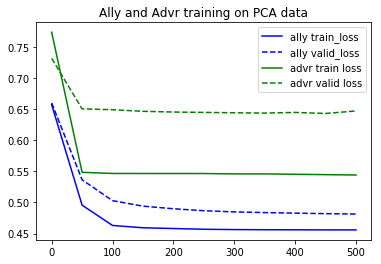

In [241]:
plt.plot(n_epoch, pca_ally_train, 'b')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_train, 'g')
plt.plot(n_epoch, pca_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on PCA data")
plt.show()

# Ally and Adversary Training on Auto-encoded data

In [242]:
lr = 0.001

network_ally_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_ae.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

ae_ally_train=[]
ae_ally_valid = []

for epoch in range(501):
    network_ally_ae.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_ae(X_train_torch_ae)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_ae.eval()
    y_ally_valid_torch_hat = network_ally_ae(X_valid_torch_ae)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    ae_ally_train.append(loss.item())
    ae_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.65611809 	 0.65391487
50 	 0.45747623 	 0.51228458
100 	 0.45311117 	 0.50615853
150 	 0.45219061 	 0.50419140
200 	 0.45178157 	 0.50306106
250 	 0.45155725 	 0.50229746
300 	 0.45141897 	 0.50173569
350 	 0.45132670 	 0.50129908
400 	 0.45126161 	 0.50094634
450 	 0.45121375 	 0.50065327
500 	 0.45117727 	 0.50040442


In [243]:
lr = 0.001

network_advr_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_ae.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

ae_advr_train = []
ae_advr_valid = []

for epoch in range(501):
    network_advr_ae.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_ae(X_train_torch_ae)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_ae.eval()
    y_advr_valid_torch_hat = network_advr_ae(X_valid_torch_ae)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    ae_advr_train.append(loss.item())
    ae_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.75198245 	 0.72961718
50 	 0.69358248 	 0.69329822
100 	 0.62371683 	 0.64671880
150 	 0.57046282 	 0.63274843
200 	 0.56349903 	 0.63275695
250 	 0.56008428 	 0.63494009
300 	 0.55883622 	 0.63489932
350 	 0.55772918 	 0.63666373
400 	 0.55645877 	 0.63741940
450 	 0.55627745 	 0.63663512
500 	 0.55617893 	 0.63665414


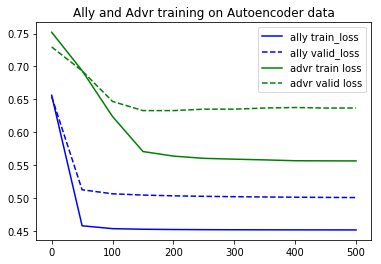

In [244]:
plt.plot(n_epoch, ae_ally_train, 'b')
plt.plot(n_epoch, ae_ally_valid, 'b--')
plt.plot(n_epoch, ae_advr_train, 'g')
plt.plot(n_epoch, ae_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

# Results

| Model | Train Ally  | Valid Ally  | Train Advr | Valid Advr |
|---|---:|---:|---:|---:|
| PCA | 0.54596204 | **0.63508838** | 0.45774460 | 0.47422782 |
| A-Enc | 0.69294691 | 0.69324082 | 0.45286497 | 0.50768989 |
| P-GAN | 0.53968185 | 0.69574529 | 0.45563743 | **0.59513420** |

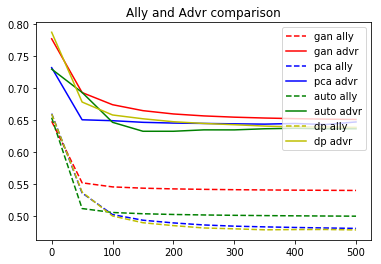

In [245]:
plt.plot(n_epoch, valid, 'r--')
plt.plot(n_epoch, valid_a, 'r')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_valid, 'b')
plt.plot(n_epoch, ae_ally_valid, 'g--')
plt.plot(n_epoch, ae_advr_valid, 'g')
plt.plot(n_epoch, dp_ally_valid, 'y--')
plt.plot(n_epoch, dp_advr_valid, 'y')
plt.legend(['gan ally', 'gan advr', 'pca ally', 'pca advr', 'auto ally', 'auto advr', 'dp ally', 'dp advr'])
plt.title("Ally and Advr comparison")
plt.show()

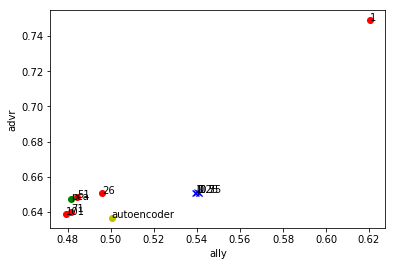

In [246]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
plt.plot([pca_ally_valid[-1]], [pca_advr_valid[-1]], 'go')
ax.annotate('%s' % 'pca', xy=(pca_ally_valid[-1], pca_advr_valid[-1]), textcoords='data')
plt.plot([ae_ally_valid[-1]], [ae_advr_valid[-1]], 'yo')
ax.annotate('%s' % 'autoencoder', xy=(ae_ally_valid[-1], ae_advr_valid[-1]), textcoords='data')
plt.xlabel('ally')
plt.ylabel('advr')
plt.show()